In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from scipy import spatial

#解决中文显示问题
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['figure.dpi'] = 150

In [3]:
network = pd.read_csv('network.csv',index_col=0)

In [4]:
network

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
197,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
198,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [5]:
x_axis = []
y_axis = []
point = []
for i in range(200):
    for j in range(200):
        if network.iloc[i,j] == 1:
            x_axis.append(i)
            y_axis.append(j)

Text(100, 100, 'Cluster 3')

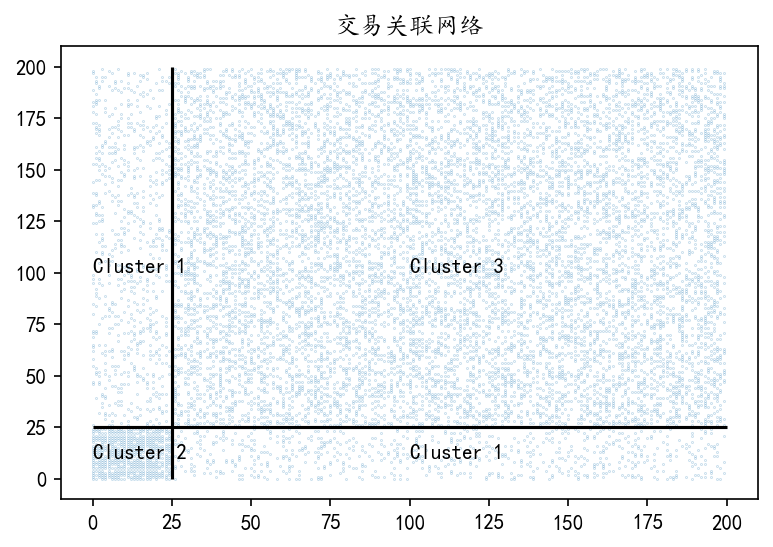

In [27]:
ax = plt.gca()
ax.set_title('交易关联网络')
ax.vlines(x=25,ymin=0,ymax=200) 
ax.hlines(y=25,xmin=0,xmax=200)
ax.scatter(x=x_axis,y=y_axis,s=1/100)
ax.text(0,100,'Cluster 1')
ax.text(100,10,'Cluster 1')
ax.text(0,10,'Cluster 2')
ax.text(100,100,'Cluster 3')


In [7]:
tag_column = np.repeat([1,0],[25,175])

In [8]:
network['tag'] = tag_column

### 假设前五个犯罪分子被抓住了

In [9]:
tag_observed_col = np.repeat([1,0],[5,195])

In [10]:
network['observed_tag'] = tag_observed_col

In [11]:
def community_forming(my_network):

    for i in range(200):
        community_candidates = [1,0]
        trade_record = my_network.iloc[i,:200]
    
        community = my_network['observed_tag'].iloc[i]
        current_member = my_network[my_network['observed_tag']==community].index
    
        times = len(trade_record[trade_record==1])
        correspondence = trade_record[trade_record==1].index.astype('int64')
        
        within_community_trade = current_member.intersection(correspondence)
    
        trade_proportion = len(within_community_trade) / times
        member_proportion = len(current_member) / 200
        
        if not trade_proportion > member_proportion:
            my_network['observed_tag'].iloc[i] = community_candidates.pop(community)
            
    return my_network['observed_tag']

In [14]:
def SLM(network,max_iter):
    last_tag = network['observed_tag']
    next_tag = community_forming(network)
    i = 0     
    while 1 - spatial.distance.cosine(last_tag, next_tag) < 0.9 and i < max_iter:
        i += 1
        last_tag = next_tag
        next_tag = community_forming(network)
        
    return next_tag

In [30]:
1 - spatial.distance.cosine(1, 1)

1.0

In [15]:
network_copy = network.copy()

In [16]:
v1 = SLM(network_copy,10)
v2 = np.array(network['tag'])

In [17]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [18]:
perf_measure(v2,v1)

(25, 7, 168, 0)

In [19]:
from sklearn.metrics import f1_score

In [20]:
f1_score(v2,v1)

0.8771929824561403